## Visualization of Gradient Graph

#### graphviz conda installation steps

Ref - [Second Answer in Stackoverflow](https://stackoverflow.com/questions/33433274/anaconda-graphviz-cant-import-after-installation)
1. `conda install graphviz`
2. `conda install python-graphviz`
3. `conda install pydot`
   
If, even after the above steps you get an `ExecutableNotFoundError` then try this  
`conda install -c conda-forge python-graphviz` 

In [1]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [2]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data 
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

d

Value(data=4.0)

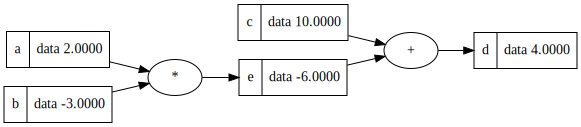

In [4]:
draw_dot(d)

#### Forward Pass

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label = 'f')
L = d * f # Graph output
L.label = 'L'

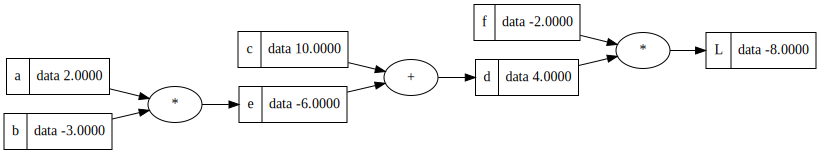

In [6]:
draw_dot(L)

This is the viusalization of the forward pass.  
For the backward pass we need to find the derivative of `L` w.r.t. `L`, `f`, `d` and so on
  
For initialization we set `grad = 0` which implies that every value does not affect the output.

In [7]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label = 'f')
L = d * f # Graph output
L.label = 'L'

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)

      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)

  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))

    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


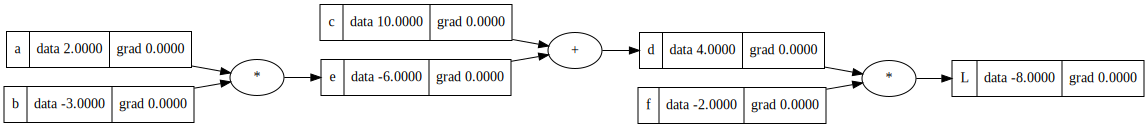

In [10]:
# Data of variables with their gradients (initialized to 0)

# Gradient represents the derivative of the output w.r.t that variable
draw_dot(L)